# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.29KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

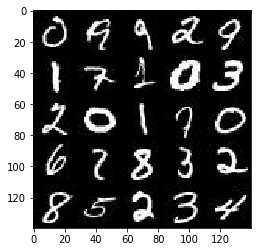

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

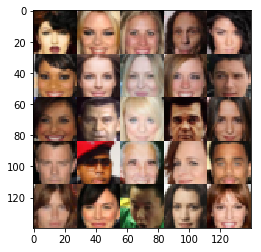

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
        
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, (None), name='learning_rate')

    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x = images
        alpha = 0.2
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        #relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.relu(x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        #relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.relu(bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        #relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.relu(bn3)
        
                
        x4 = tf.layers.conv2d(relu3, 512, 3, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        #relu4 = tf.maximum(alpha * bn4, bn4)
        relu4 = tf.nn.relu(bn4)

        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits        
                                

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    alpha = 0.2
    
    if is_train:
        reuse = False
    else:
        reuse = True
    
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        x4 = tf.layers.conv2d_transpose(relu3, 32, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * bn4, bn4)
                                        
        # Output layer
        x5 = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(x5, [28,28])
        out = tf.tanh(logits)
        return out    
        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    alpha = 0.2

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
            
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
            
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    steps = 0
    
    input_real, input_z, l = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    n_images = 10 
    
    print_every = 10
    
    show_every = 100 
    
    sample_z = np.random.uniform(-1, 1, size=(9, z_dim))
    
    samples, losses = [], []
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            print()
            for x in get_batches(batch_size):
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: x})
                
                
                if steps % print_every == 0:
                    
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:                    
                    
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    
                    samples.append(gen_samples)
                    
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                
                                                                                                                                                                       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.


Epoch 1/2... Discriminator Loss: 0.0351... Generator Loss: 4.0872
Epoch 1/2... Discriminator Loss: 0.8689... Generator Loss: 0.6984
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.3449
Epoch 1/2... Discriminator Loss: 0.4211... Generator Loss: 1.3355
Epoch 1/2... Discriminator Loss: 0.2171... Generator Loss: 8.3114
Epoch 1/2... Discriminator Loss: 0.2487... Generator Loss: 1.7428
Epoch 1/2... Discriminator Loss: 1.8861... Generator Loss: 0.2425
Epoch 1/2... Discriminator Loss: 0.4233... Generator Loss: 2.8427
Epoch 1/2... Discriminator Loss: 0.2436... Generator Loss: 2.2627
Epoch 1/2... Discriminator Loss: 0.1267... Generator Loss: 4.6423


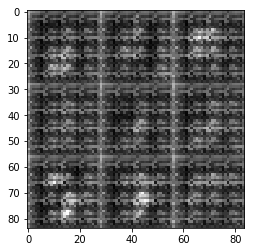

Epoch 1/2... Discriminator Loss: 0.3188... Generator Loss: 2.1184
Epoch 1/2... Discriminator Loss: 0.3951... Generator Loss: 1.7891
Epoch 1/2... Discriminator Loss: 0.3537... Generator Loss: 1.7432
Epoch 1/2... Discriminator Loss: 0.2960... Generator Loss: 5.1100
Epoch 1/2... Discriminator Loss: 0.3722... Generator Loss: 2.1706
Epoch 1/2... Discriminator Loss: 0.3227... Generator Loss: 2.8010
Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 0.2614... Generator Loss: 2.7185
Epoch 1/2... Discriminator Loss: 0.2255... Generator Loss: 2.4783
Epoch 1/2... Discriminator Loss: 0.4306... Generator Loss: 1.3145


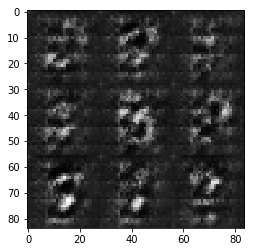

Epoch 1/2... Discriminator Loss: 0.1990... Generator Loss: 2.5962
Epoch 1/2... Discriminator Loss: 0.6211... Generator Loss: 4.8861
Epoch 1/2... Discriminator Loss: 1.0349... Generator Loss: 5.4342
Epoch 1/2... Discriminator Loss: 0.3730... Generator Loss: 2.7163
Epoch 1/2... Discriminator Loss: 0.4081... Generator Loss: 1.4693
Epoch 1/2... Discriminator Loss: 0.4020... Generator Loss: 2.1308
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 5.6773
Epoch 1/2... Discriminator Loss: 0.4826... Generator Loss: 2.0691
Epoch 1/2... Discriminator Loss: 0.4721... Generator Loss: 1.4581
Epoch 1/2... Discriminator Loss: 0.4436... Generator Loss: 1.5215


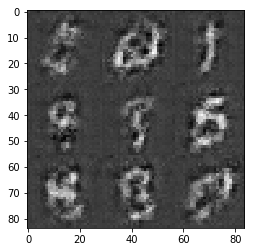

Epoch 1/2... Discriminator Loss: 0.3283... Generator Loss: 2.6270
Epoch 1/2... Discriminator Loss: 0.3986... Generator Loss: 1.6093
Epoch 1/2... Discriminator Loss: 0.3157... Generator Loss: 1.7697
Epoch 1/2... Discriminator Loss: 0.6640... Generator Loss: 5.1644
Epoch 1/2... Discriminator Loss: 0.3717... Generator Loss: 1.6175
Epoch 1/2... Discriminator Loss: 0.2796... Generator Loss: 2.0752
Epoch 1/2... Discriminator Loss: 0.2605... Generator Loss: 2.5494
Epoch 1/2... Discriminator Loss: 1.9655... Generator Loss: 0.1938
Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 0.7622
Epoch 1/2... Discriminator Loss: 0.2932... Generator Loss: 1.9556


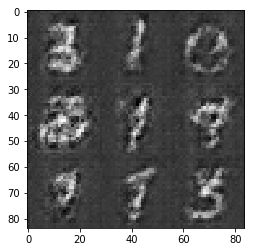

Epoch 1/2... Discriminator Loss: 0.4448... Generator Loss: 1.4221
Epoch 1/2... Discriminator Loss: 0.2318... Generator Loss: 2.9039
Epoch 1/2... Discriminator Loss: 2.1482... Generator Loss: 2.7629
Epoch 1/2... Discriminator Loss: 0.5567... Generator Loss: 1.2421
Epoch 1/2... Discriminator Loss: 0.4663... Generator Loss: 1.3032
Epoch 1/2... Discriminator Loss: 0.3857... Generator Loss: 1.7452
Epoch 1/2... Discriminator Loss: 0.4011... Generator Loss: 1.5203
Epoch 1/2... Discriminator Loss: 0.2089... Generator Loss: 2.2755
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 0.5934
Epoch 1/2... Discriminator Loss: 0.3280... Generator Loss: 1.7329


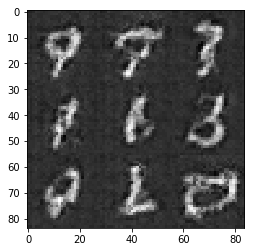

Epoch 1/2... Discriminator Loss: 0.1625... Generator Loss: 2.4897
Epoch 1/2... Discriminator Loss: 0.1320... Generator Loss: 3.3508
Epoch 1/2... Discriminator Loss: 0.2479... Generator Loss: 2.0031
Epoch 1/2... Discriminator Loss: 0.2144... Generator Loss: 2.1654
Epoch 1/2... Discriminator Loss: 0.2986... Generator Loss: 1.6736
Epoch 1/2... Discriminator Loss: 1.6979... Generator Loss: 6.1839
Epoch 1/2... Discriminator Loss: 0.4949... Generator Loss: 1.4884
Epoch 1/2... Discriminator Loss: 0.5408... Generator Loss: 1.3391
Epoch 1/2... Discriminator Loss: 0.4219... Generator Loss: 1.3588
Epoch 1/2... Discriminator Loss: 0.0950... Generator Loss: 3.2844


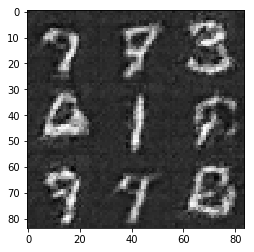


Epoch 2/2... Discriminator Loss: 0.6290... Generator Loss: 1.1069
Epoch 2/2... Discriminator Loss: 0.3246... Generator Loss: 1.5365
Epoch 2/2... Discriminator Loss: 0.1939... Generator Loss: 2.2614
Epoch 2/2... Discriminator Loss: 0.7793... Generator Loss: 7.8667
Epoch 2/2... Discriminator Loss: 0.0984... Generator Loss: 4.0780
Epoch 2/2... Discriminator Loss: 0.0900... Generator Loss: 3.3909
Epoch 2/2... Discriminator Loss: 0.1329... Generator Loss: 2.6660
Epoch 2/2... Discriminator Loss: 0.0838... Generator Loss: 3.6911
Epoch 2/2... Discriminator Loss: 0.1302... Generator Loss: 4.5750
Epoch 2/2... Discriminator Loss: 0.0814... Generator Loss: 3.5915


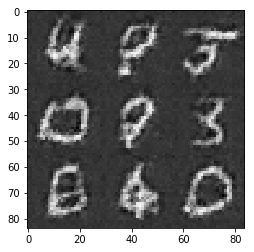

Epoch 2/2... Discriminator Loss: 0.0438... Generator Loss: 4.7672
Epoch 2/2... Discriminator Loss: 0.0410... Generator Loss: 4.8910
Epoch 2/2... Discriminator Loss: 0.1375... Generator Loss: 3.0221
Epoch 2/2... Discriminator Loss: 0.0412... Generator Loss: 4.4347
Epoch 2/2... Discriminator Loss: 1.0019... Generator Loss: 0.5401
Epoch 2/2... Discriminator Loss: 0.2384... Generator Loss: 2.0280
Epoch 2/2... Discriminator Loss: 0.0923... Generator Loss: 3.1056
Epoch 2/2... Discriminator Loss: 0.2755... Generator Loss: 1.7833
Epoch 2/2... Discriminator Loss: 1.3288... Generator Loss: 0.4073
Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 1.8995


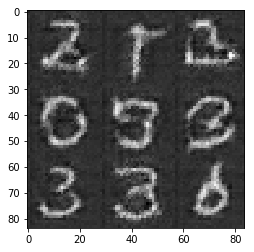

Epoch 2/2... Discriminator Loss: 0.4893... Generator Loss: 1.3618
Epoch 2/2... Discriminator Loss: 0.7501... Generator Loss: 0.7804
Epoch 2/2... Discriminator Loss: 0.6024... Generator Loss: 1.0876
Epoch 2/2... Discriminator Loss: 0.4287... Generator Loss: 1.4525
Epoch 2/2... Discriminator Loss: 0.3574... Generator Loss: 1.6895
Epoch 2/2... Discriminator Loss: 0.1641... Generator Loss: 3.0868
Epoch 2/2... Discriminator Loss: 0.1872... Generator Loss: 2.2576
Epoch 2/2... Discriminator Loss: 0.1001... Generator Loss: 3.2741
Epoch 2/2... Discriminator Loss: 0.2935... Generator Loss: 1.6327
Epoch 2/2... Discriminator Loss: 0.1533... Generator Loss: 2.6253


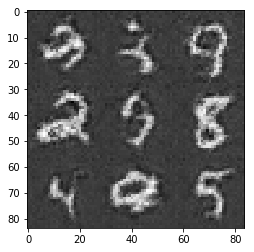

Epoch 2/2... Discriminator Loss: 0.1789... Generator Loss: 2.1904
Epoch 2/2... Discriminator Loss: 0.8888... Generator Loss: 0.7047
Epoch 2/2... Discriminator Loss: 0.6552... Generator Loss: 1.2856
Epoch 2/2... Discriminator Loss: 0.5604... Generator Loss: 1.2524
Epoch 2/2... Discriminator Loss: 0.2729... Generator Loss: 2.0503
Epoch 2/2... Discriminator Loss: 0.5333... Generator Loss: 1.2512
Epoch 2/2... Discriminator Loss: 0.1843... Generator Loss: 2.1409
Epoch 2/2... Discriminator Loss: 0.1834... Generator Loss: 2.3638
Epoch 2/2... Discriminator Loss: 0.4668... Generator Loss: 1.1581
Epoch 2/2... Discriminator Loss: 0.3630... Generator Loss: 1.4617


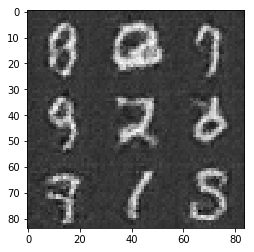

Epoch 2/2... Discriminator Loss: 0.1172... Generator Loss: 2.6322
Epoch 2/2... Discriminator Loss: 0.2069... Generator Loss: 2.0094
Epoch 2/2... Discriminator Loss: 0.0904... Generator Loss: 3.3434
Epoch 2/2... Discriminator Loss: 0.1967... Generator Loss: 2.1819
Epoch 2/2... Discriminator Loss: 0.0478... Generator Loss: 4.6039
Epoch 2/2... Discriminator Loss: 0.2078... Generator Loss: 4.5357
Epoch 2/2... Discriminator Loss: 0.0834... Generator Loss: 3.0536
Epoch 2/2... Discriminator Loss: 0.2748... Generator Loss: 1.7446
Epoch 2/2... Discriminator Loss: 2.0245... Generator Loss: 0.2516
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 1.5938


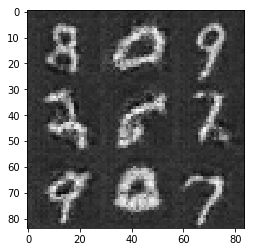

Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 0.5538
Epoch 2/2... Discriminator Loss: 0.3620... Generator Loss: 1.7193
Epoch 2/2... Discriminator Loss: 0.5025... Generator Loss: 2.4266
Epoch 2/2... Discriminator Loss: 0.7137... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 0.8824... Generator Loss: 4.1040
Epoch 2/2... Discriminator Loss: 0.4336... Generator Loss: 1.3251
Epoch 2/2... Discriminator Loss: 0.3719... Generator Loss: 1.4906
Epoch 2/2... Discriminator Loss: 0.2756... Generator Loss: 1.8853
Epoch 2/2... Discriminator Loss: 0.1523... Generator Loss: 2.9660
Epoch 2/2... Discriminator Loss: 0.1078... Generator Loss: 3.3078


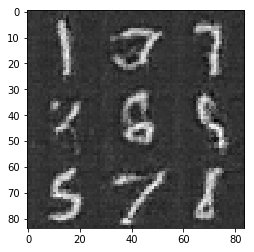

In [12]:
batch_size = 100
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

tf.reset_default_graph()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.


Epoch 1/1... Discriminator Loss: 0.0702... Generator Loss: 13.0401
Epoch 1/1... Discriminator Loss: 0.0022... Generator Loss: 10.4387
Epoch 1/1... Discriminator Loss: 0.0164... Generator Loss: 5.0407
Epoch 1/1... Discriminator Loss: 0.3071... Generator Loss: 2.7777
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 1.1872
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 1.6560
Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.2149


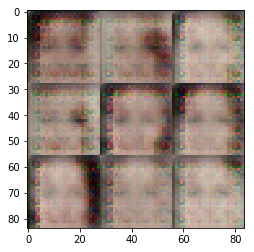

Epoch 1/1... Discriminator Loss: 2.1693... Generator Loss: 3.7819
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 1.5531
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 1.8788
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.4253
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.3786


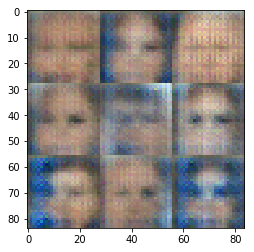

Epoch 1/1... Discriminator Loss: 1.8068... Generator Loss: 2.3267
Epoch 1/1... Discriminator Loss: 2.0738... Generator Loss: 0.2146
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.0220


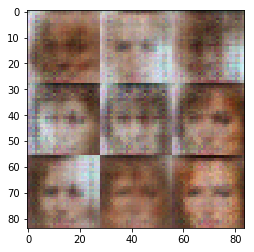

Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.4446
Epoch 1/1... Discriminator Loss: 1.9943... Generator Loss: 3.0353
Epoch 1/1... Discriminator Loss: 0.7877... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.6675... Generator Loss: 0.3561
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.4320
Epoch 1/1... Discriminator Loss: 2.2365... Generator Loss: 0.1892
Epoch 1/1... Discriminator Loss: 1.7926... Generator Loss: 3.2937


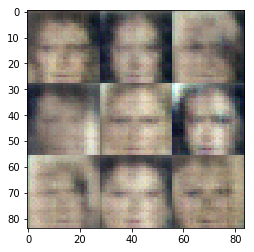

Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 1.7789
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 1.8295
Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 1.8701... Generator Loss: 2.9397
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 1.7813
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.4509
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 0.4711... Generator Loss: 1.6785
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 0.9314


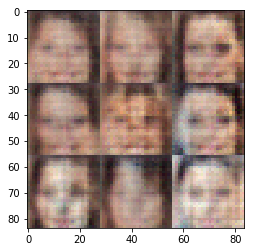

Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.3543
Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 2.6299... Generator Loss: 0.1043
Epoch 1/1... Discriminator Loss: 1.8136... Generator Loss: 0.3305
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.5036
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.6878
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 2.0510
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.1897


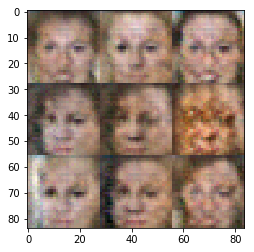

Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 1.0790
Epoch 1/1... Discriminator Loss: 0.6344... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 2.4558... Generator Loss: 0.1231
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 1.4896
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 0.5556... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.6117


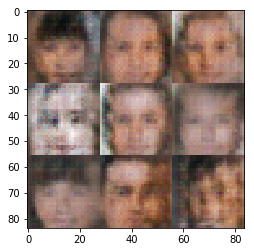

Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.3477
Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 0.7307... Generator Loss: 1.9585
Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 2.8594
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 1.6848
Epoch 1/1... Discriminator Loss: 1.6411... Generator Loss: 0.2864


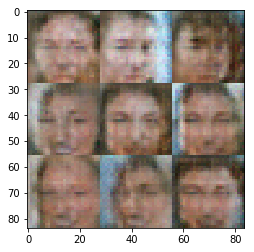

Epoch 1/1... Discriminator Loss: 1.8547... Generator Loss: 0.3293
Epoch 1/1... Discriminator Loss: 2.0987... Generator Loss: 0.2421
Epoch 1/1... Discriminator Loss: 0.4785... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 3.0426... Generator Loss: 0.0711
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 1.5895
Epoch 1/1... Discriminator Loss: 0.5515... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.6239... Generator Loss: 0.3479
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 0.8497


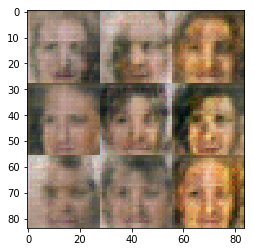

Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 1.4528
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 2.7834
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.4900
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 2.5089
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 3.5217
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 0.9947


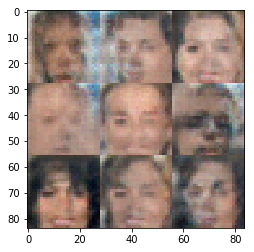

Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.2264
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 1.1401
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 2.0559
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.7329... Generator Loss: 0.2784
Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 2.3333
Epoch 1/1... Discriminator Loss: 0.6050... Generator Loss: 1.0946


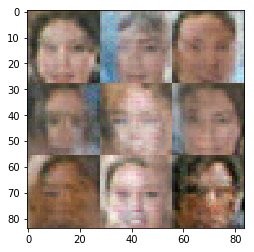

Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 1.0497
Epoch 1/1... Discriminator Loss: 1.6281... Generator Loss: 0.2941
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.4132
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.3288
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 2.7036


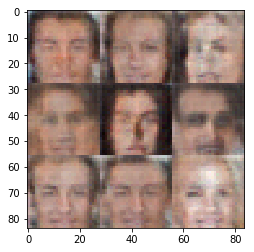

Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.4237
Epoch 1/1... Discriminator Loss: 1.6828... Generator Loss: 4.1772
Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.0132
Epoch 1/1... Discriminator Loss: 2.1406... Generator Loss: 0.1724
Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 0.2437
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.5920
Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 3.1424
Epoch 1/1... Discriminator Loss: 0.7070... Generator Loss: 1.0288


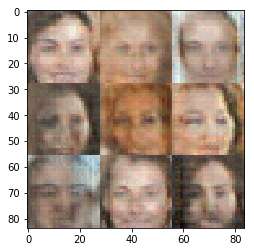

Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 0.6557... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 0.8661... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.6433... Generator Loss: 4.1644
Epoch 1/1... Discriminator Loss: 2.0655... Generator Loss: 0.1854
Epoch 1/1... Discriminator Loss: 1.7507... Generator Loss: 4.6942
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 2.0432... Generator Loss: 0.1767
Epoch 1/1... Discriminator Loss: 1.9472... Generator Loss: 0.2123
Epoch 1/1... Discriminator Loss: 1.6655... Generator Loss: 0.2824


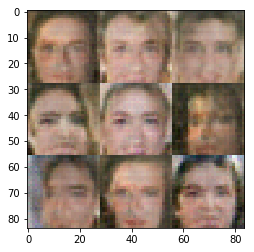

Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 2.0349... Generator Loss: 0.1767
Epoch 1/1... Discriminator Loss: 3.2190... Generator Loss: 0.0591
Epoch 1/1... Discriminator Loss: 1.8882... Generator Loss: 0.2233
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 2.4426
Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.3165
Epoch 1/1... Discriminator Loss: 0.6747... Generator Loss: 1.5403
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 1.7794
Epoch 1/1... Discriminator Loss: 0.4413... Generator Loss: 2.5383


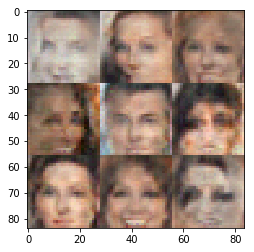

Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 1.7656
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 0.9736
Epoch 1/1... Discriminator Loss: 0.4401... Generator Loss: 1.8985
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.4115
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.4235
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.4718
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.3666


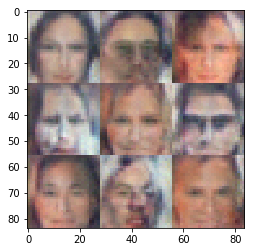

Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 1.6450
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.3052
Epoch 1/1... Discriminator Loss: 2.2588... Generator Loss: 4.9463
Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 1.1587
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.3633
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.2439
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 1.7628
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.5862


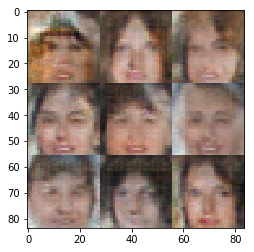

Epoch 1/1... Discriminator Loss: 1.6142... Generator Loss: 0.2894
Epoch 1/1... Discriminator Loss: 2.2669... Generator Loss: 0.1488
Epoch 1/1... Discriminator Loss: 0.6043... Generator Loss: 1.3066
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 3.9238
Epoch 1/1... Discriminator Loss: 2.1447... Generator Loss: 0.1673
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.4469
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 1.5639
Epoch 1/1... Discriminator Loss: 2.5965... Generator Loss: 0.1051
Epoch 1/1... Discriminator Loss: 2.1714... Generator Loss: 0.1607


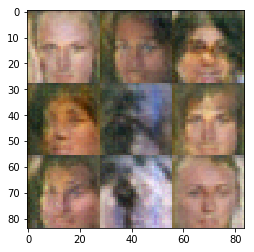

Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 2.7147
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.6821... Generator Loss: 0.2695
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.5247
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 0.6477


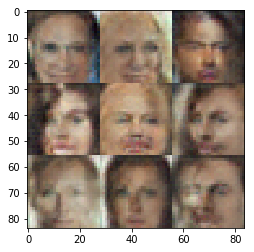

Epoch 1/1... Discriminator Loss: 2.0236... Generator Loss: 0.2084
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.3294
Epoch 1/1... Discriminator Loss: 2.0962... Generator Loss: 0.2035
Epoch 1/1... Discriminator Loss: 1.6933... Generator Loss: 0.2796
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 2.9150
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 1.8706
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 2.4717
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 1.2690


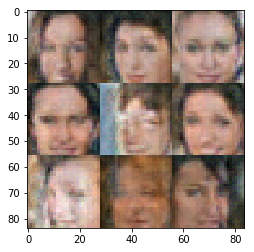

Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 0.7497... Generator Loss: 2.1618
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.3437
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 2.6852
Epoch 1/1... Discriminator Loss: 1.8404... Generator Loss: 0.2218
Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 1.2925
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 2.0276... Generator Loss: 0.1758


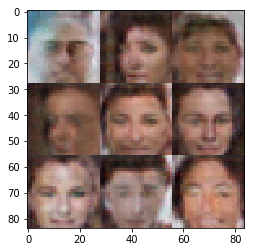

Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.4355
Epoch 1/1... Discriminator Loss: 0.7046... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 1.8914... Generator Loss: 0.2193
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 0.4927... Generator Loss: 2.3710
Epoch 1/1... Discriminator Loss: 1.0306... Generator Loss: 0.6058
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.3962
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 0.9378


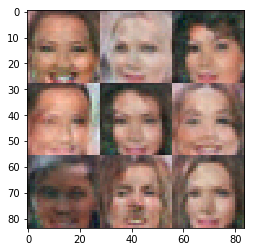

Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.3340
Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.7520
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.4408
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.0155
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.3132
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 0.8005


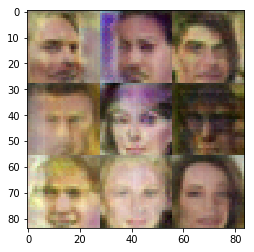

Epoch 1/1... Discriminator Loss: 2.2232... Generator Loss: 0.1751
Epoch 1/1... Discriminator Loss: 1.8761... Generator Loss: 0.2424
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.3966
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 1.1063
Epoch 1/1... Discriminator Loss: 1.6566... Generator Loss: 0.2738
Epoch 1/1... Discriminator Loss: 0.5782... Generator Loss: 1.7385
Epoch 1/1... Discriminator Loss: 2.0905... Generator Loss: 4.1993
Epoch 1/1... Discriminator Loss: 1.6405... Generator Loss: 0.3372
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 1.2884


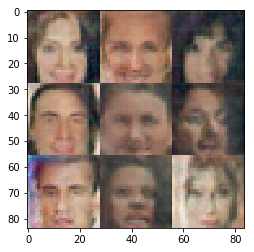

Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.4140
Epoch 1/1... Discriminator Loss: 0.6161... Generator Loss: 1.5300
Epoch 1/1... Discriminator Loss: 2.1220... Generator Loss: 0.1560
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 2.1292
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.7134... Generator Loss: 0.2713
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 0.5170... Generator Loss: 2.2579
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.0127


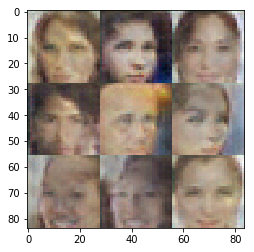

Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.5934
Epoch 1/1... Discriminator Loss: 2.5193... Generator Loss: 0.1120
Epoch 1/1... Discriminator Loss: 0.4897... Generator Loss: 1.7032
Epoch 1/1... Discriminator Loss: 1.9271... Generator Loss: 2.9035
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.8262
Epoch 1/1... Discriminator Loss: 0.3962... Generator Loss: 1.7761
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 0.9475
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.4221


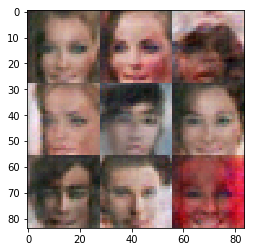

Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.3927
Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 2.0879
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 3.5365
Epoch 1/1... Discriminator Loss: 0.8078... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.3422
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 0.6410... Generator Loss: 1.4047
Epoch 1/1... Discriminator Loss: 2.7792... Generator Loss: 0.0845


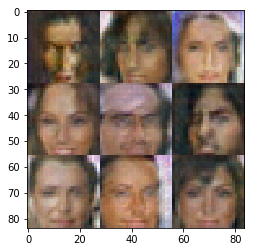

Epoch 1/1... Discriminator Loss: 2.1096... Generator Loss: 0.1871
Epoch 1/1... Discriminator Loss: 2.6543... Generator Loss: 0.1211
Epoch 1/1... Discriminator Loss: 0.5248... Generator Loss: 1.4435
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 0.6903... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 0.6090... Generator Loss: 1.4155
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 1.4815
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.5646


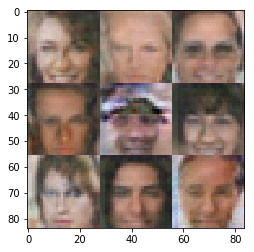

Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 0.9202
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 2.6559
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.4161
Epoch 1/1... Discriminator Loss: 1.9405... Generator Loss: 3.9203
Epoch 1/1... Discriminator Loss: 2.3090... Generator Loss: 0.1431
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 2.7520
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.9758


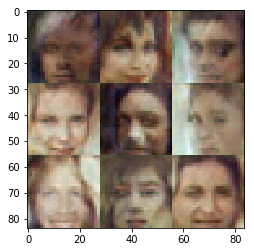

Epoch 1/1... Discriminator Loss: 2.6290... Generator Loss: 0.1153
Epoch 1/1... Discriminator Loss: 0.6312... Generator Loss: 1.4058
Epoch 1/1... Discriminator Loss: 0.9121... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.3824
Epoch 1/1... Discriminator Loss: 1.6945... Generator Loss: 0.2503
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.6253
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 2.4121
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 2.1743


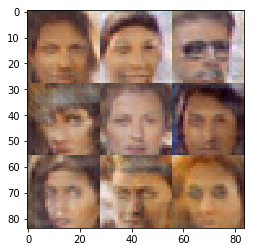

Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 0.4070... Generator Loss: 1.8427
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 3.7842
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 0.5588... Generator Loss: 1.4358
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.5194
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 0.8782... Generator Loss: 0.7490


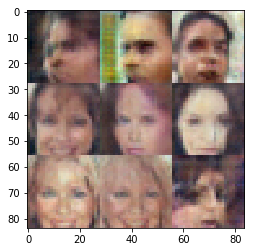

Epoch 1/1... Discriminator Loss: 0.4244... Generator Loss: 1.3950
Epoch 1/1... Discriminator Loss: 0.3364... Generator Loss: 2.7137
Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 1.3691
Epoch 1/1... Discriminator Loss: 1.7299... Generator Loss: 0.2562
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.2970


In [13]:
batch_size = 64
z_dim = 90
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.